In [3]:
import pandas as pd
import numpy as np
import gurobipy as gp

import warnings
warnings.filterwarnings("ignore")

In [105]:
#function to generate coefficients
def get_betas(df,k):

    #create the X matrix from the dataframe
    X= df.drop(columns='y')
    
    #insert the first column made up entirely of 1's
    X.insert(0, 'ones', 1)
    X_arr=np.array(X)
    
    #create the y matrix from the dataframe
    y_arr= np.array(df['y'])
    
    #number of independent variables
    m = len(df.columns)-1
    
    #number of datapoints
    n = len(df)
    
    #setting the first (m+1) components as -2yTX, and the rest as zeros
    obj = np.zeros((2*m+1))
    obj[0:m+1] = -2*(y_arr.T @ X_arr)
    
    #initialize the Q matrix with (2m+1)rows and (2m+1) columns
    Q = np.zeros((2*m + 1,2*m + 1))
    
    #setting the upper left corner of the Q matrix as the product of X-transpose and X
    X_Transp_X= X.T @ X
    Q[0:X_Transp_X.shape[0], 0:X_Transp_X.shape[1]]= X_Transp_X
    
    #big M value=100
    M=100
    
    #initialize the constraint matrix (2m+1)*(2m+1)
    A = np.zeros((2*m+1,2*m+1))
    
    #big M constraint: 𝛽-𝑀𝑧 ≤ 0
    for i in range(0,m):
        A[i,1+i] = 1
        A[i,m+i] = -M
    
    #big M constraint: 0 ≤ 𝛽+𝑀𝑧
    for i in range(0,m):
        A[50+i,1+i] = 1
        A[50+i,m+i] = M
    
    #3rd constraint: number of variables with non zero coefficients should be lesser than equal to k
    A[2*m,:][m+1:] = 1
    
    #sense array
    sense = ['<']*m + ['>']*m + ['<'] 
    
    #setting the rhs of the inequalities
    b = np.array([0]*m +[0]*m + [k])
    
    #setting the lower bound for the betas as -M 
    lb=np.array([np.NINF]+[-M]*m+[0]*m)
    
    #Gurobi starts
    varSelMod = gp.Model()
    
    #add variable types - the (m+1) coefficients are continuous and the z's are binary variables, set lower bound
    varSelMod_x = varSelMod.addMVar((2*m)+1, vtype = ['C']*(m+1) + ['B']*m, lb=lb)
    
    varSelMod_con = varSelMod.addMConstr(A, varSelMod_x, sense, b)
    
    #input the linear objective and Q matrix to objective
    varSelMod.setMObjective(Q,obj,0,sense=gp.GRB.MINIMIZE)

    varSelMod.Params.OutputFlag = 0 
    
    #setting the time limit for Gurobi
    varSelMod.Params.TimeLimit = 3600

    varSelMod.optimize()
    
    #return the best betas found by Gurobi
    return varSelMod.x[:m+1]

In [106]:
#read the training data file
train_data = pd.read_csv('training_data.csv')


coefficients=get_betas(train_data, 10)
coefficients

[0.972524076551512,
 -3.637978807091713e-12,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -2.30820726193799,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.5183261233655834,
 -0.20416201346664947,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.5591431785875267,
 0.8669733628925481,
 0.0,
 -1.3119194151232525,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.40816530330537165,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.7814748910756226,
 0.0,
 0.8873829240134911,
 -0.28229212764185496,
 0.0,
 0.0]

## 2

In [20]:
k_level_errors={}

#cross validation function
def cross_validation(df):
    
    #define the values of k (number of variables we want to select from X) to loop through
    start=5
    end=51
    steps= 5
    
    
    for k in range(start,end,steps):
        
        #list for storing error values for every value of k
        squared_err_list=[]
        
        #10 fold cv for every value of k
        for folds in range(10):
            
            #get random indices from the data and generate the train and validation set for cross validation
            validatn_idx=np.random.choice(range(0,len(df)),int(len(df)/10), replace=False)w
            valid_data=df.iloc[validatn_idx]
            train_data=df.drop(validatn_idx, axis=0)

            X_valid= valid_data.drop(columns='y')
            X_valid.insert(0, 'ones', 1)
            X_valid_arr=np.array(X_valid)

            y_valid=valid_data['y']
            
            #get the best coefficients for the training data
            coefficients=get_betas(train_data,k)
            
            #get absolute error on validation set
            error = (X_valid_arr @ coefficients) - y_valid
            
            #get sum of squared errors
            squared_error = sum(error**2)
            squared_err_list.append(squared_error)
        
        #append SSE for every value of k to the dictionary with key as the k value
        k_level_errors[k]=sum(squared_err_list)
        print('For k={}, the SSE is {}'.format(k,sum(squared_err_list)))
    
    #return the sum of squared errors for every value of k
    return k_level_errors

In [21]:
k_level_errors=cross_validation(train_data)
k_level_errors

For k=5, the SSE is 1032.7577333109411
For k=10, the SSE is 659.5483098661165
For k=15, the SSE is 758.0941765445439
For k=20, the SSE is 953.5665755919529
For k=25, the SSE is 808.6038991527558
For k=30, the SSE is 846.875862138619
For k=35, the SSE is 885.4049392107265
For k=40, the SSE is 826.1504540882653
For k=45, the SSE is 956.0798501276781
For k=50, the SSE is 813.2790215268449


{5: 1032.7577333109411,
 10: 659.5483098661165,
 15: 758.0941765445439,
 20: 953.5665755919529,
 25: 808.6038991527558,
 30: 846.875862138619,
 35: 885.4049392107265,
 40: 826.1504540882653,
 45: 956.0798501276781,
 50: 813.2790215268449}

<AxesSubplot:xlabel='K Values', ylabel='SSE'>

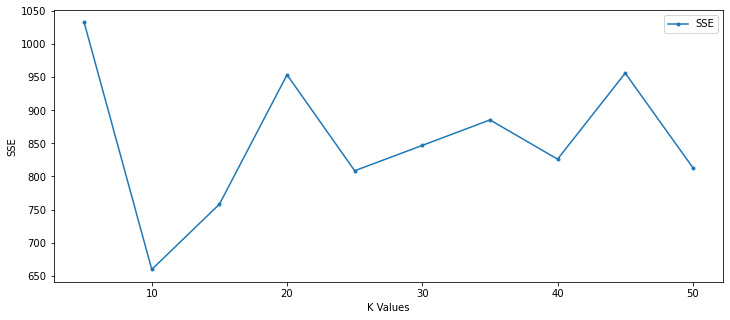

In [32]:
#k_vs_sse = dict(zip([5,10,15,20,25,30,35,40,45,50], k_level_errors))
df_err=pd.DataFrame(k_level_errors.items(), columns=['k','SSE'])
df_err.set_index('k').plot(kind='line', xlabel='K Values', ylabel= 'SSE', marker='.', figsize=(12,5))

## 3

In [33]:
#read train data and get the beta values
df_train = pd.read_csv('training_data.csv')

#get best value of k
optimal_k= min(k_level_errors, key=k_level_errors.get)

#get coefficients for the training data for the above value of k
coeffs=get_betas(df_train,optimal_k)

In [92]:
#read the test data from the file and form the X and y matrix for the test data
test_data = pd.read_csv('test_data.csv')
X_test= test_data.drop(columns='y')
X_test.insert(0, 'ones', 1)
X_test_arr=np.array(X_test)
y_test_arr= np.array(test_data['y'])

# get the absolute and sum of squared error on the test data
test_error = (X_test_arr @ coeffs) - y_test_arr
sse_gurobi = sum(test_error**2)

In [93]:
sse_gurobi

116.82719822772683

## 4. Lasso using sklearn

In [90]:
from sklearn.linear_model import Lasso, LassoCV

X_train=df_train.drop(columns='y')
y_train= df_train['y']

#using LassoCv to get the best lambda(regularization penalty) and training the data with this value
lassocv = LassoCV(alphas = None, cv = 10)
lassocv.fit(X_train, y_train)
lasso=Lasso()
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)

#predict on test data
y_pred=lasso.predict(test_data.drop(columns='y'))
y_test=test_data['y']

#calculate SSE
squared_test_error_lasso = sum((y_pred-y_test)**2)

#print best lambda value
print('Best Value of lambda:',lassocv.alpha_ )

print('SSE on test data for Lasso:',squared_test_error_lasso)

Best Value of lambda: 0.07638765995113514
SSE on test data for Lasso: 117.48173795802899


## Comparison of Coefficients from both the models

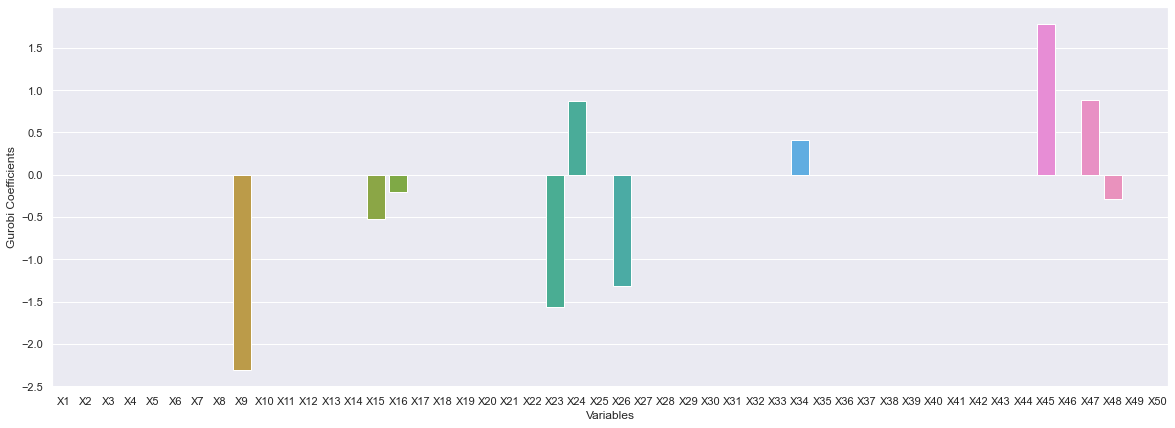

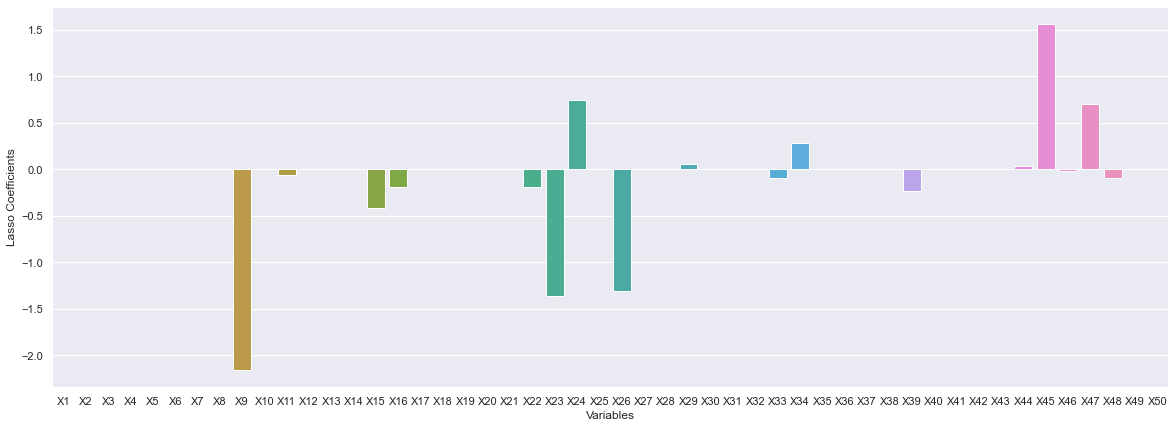

In [79]:
#create a df with the coefficients of every variable from both the models
df_coeff=pd.DataFrame(
    {
        'Variables':X_train.columns,
        'Gurobi Coefficients': coeffs[1:],
     'Lasso Coefficients': lasso.coef_
    })

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20,7)})
sns.barplot(data=df_coeff, x='Variables', y='Gurobi Coefficients')
plt.show()
sns.barplot(data=df_coeff, x='Variables', y='Lasso Coefficients')
plt.show()

## Comparison of Errors from both the models

In [100]:
df_sse_error=pd.DataFrame(columns=['OLS with Gurobi Optimization', 'OLS'], index=['SSE'])
df_mse_error=pd.DataFrame(columns=['OLS with Gurobi Optimization', 'OLS'], index=['MSE'])

In [101]:
df_sse_error.loc['SSE']=[sse_gurobi,squared_test_error_lasso]

In [102]:
df_sse_error

,OLS with Gurobi Optimization,OLS
SSE,116.827198,117.481738
